In [1]:
import warnings;
warnings.filterwarnings('ignore');

In [208]:
import pandas as pd
from my_utils import loader
import os
import pymc3 as pm
import arviz as az
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error
from theano import tensor as T
import matplotlib.pyplot as plt

In [3]:
quest_before = pd.read_csv("datasets/EyeT/Questionnaire_datasetIA.csv")
quest_before.index.name = "Participant"
quest_before.head()

,Participant nr,NR,Created,Modified,Consent,Q1,Q2,Q3,Q4,Q5,...,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Total Score extended,Total Score original,Elapsed time
Participant,,,,,,,,,,,,,,,,,,,,,
1,9199452,07.09.2020 15:13,07.09.2020 15:13,Yes,Proceed,3,3,4,4,3,...,1,4,4,4,1,3,4,134,108,5 minutes 5 seconds
2,9584002,30.09.2020 11:23,30.09.2020 11:23,Yes,Proceed,3,3,4,4,4,...,2,4,3,3,4,2,2,133,105,5 minutes 55 seconds
3,9112363,02.09.2020 09:17,02.09.2020 09:17,Yes,Proceed,2,2,3,4,3,...,3,3,3,3,3,3,3,116,81,6 minutes 49 seconds
4,9727754,06.10.2020 13:20,06.10.2020 13:20,Yes,Proceed,2,3,4,3,2,...,2,3,4,4,2,4,2,114,96,8 minutes 39 seconds
5,9730232,06.10.2020 14:53,06.10.2020 14:53,Yes,Proceed,3,3,4,4,3,...,1,4,2,1,4,4,4,138,106,7 minutes 27 seconds


In [4]:
REGRESSOR_FIX = [
    "B_drift_00_mean",
    "B_drift_11_mean", 
    "B_cross_mean",
    "B_drift_00_sd", 
    "B_drift_11_sd",
    "B_cross_sd", 
    "Sigma_00_mean",
    "Sigma_11_mean",
    "Sigma_cross_mean",
    "Sigma_00_sd",
    "Sigma_11_sd",
    "Sigma_cross_sd",
    "fdur",
    "left_pupil",
    "right_pupil"
]

In [5]:
REGRESSOR_SAC = [
    "B_drift_00_mean",
    "B_drift_11_mean",
    "B_cross_mean",
    "B_drift_00_sd",
    "B_drift_11_sd",
    "B_cross_sd",
    "Sigma_00_mean",
    "Sigma_11_mean",
    "Sigma_cross_mean",
    "Sigma_00_sd",
    "Sigma_11_sd",
    "Sigma_cross_sd",
    "angle",
    "amplitude",
    "duration"
]

## __Free viewing__

<AxesSubplot: >

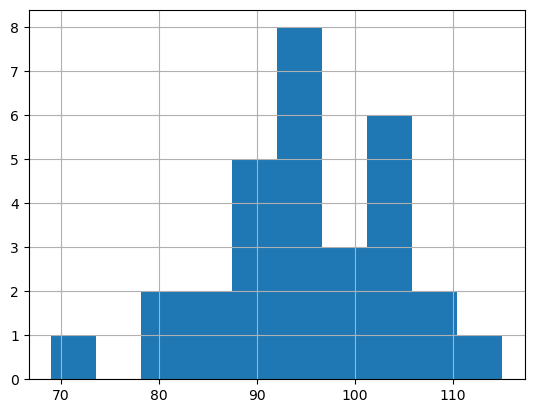

In [9]:
free_viewing_empathy = quest_before[quest_before.index%2 == 0]["Total Score original"]
free_viewing_empathy.hist()

### __Fixations__

In [7]:
AGGREGATED_PATH = "output/aggregated_features/"

def get_fix_free_features(sub_nr, dset="test"):
    with open(
        f"{AGGREGATED_PATH}/{dset}/event_features_{sub_nr:02}_agg.pickle", "rb"
    ) as f:
        fix_features = pickle.load(f)[0]
    labels = np.repeat(free_viewing_empathy[sub_nr], len(fix_features))
    return fix_features, labels

In [10]:
free_fix_train_features = []
free_fix_train_labels = []

for filename in os.listdir(f"{AGGREGATED_PATH}/train/"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr % 2 == 0:
        features, labels = get_fix_free_features(sub_nr)
        for feature in features:
            free_fix_train_features.append(feature)
        for label in labels:
            free_fix_train_labels.append(label)

free_fix_features_train = np.array(free_fix_train_features)
free_fix_features_train = (free_fix_features_train - free_fix_features_train.min(axis=0))/(free_fix_features_train.max(axis=0)-free_fix_features_train.min(axis=0))
free_fix_labels = np.array(free_fix_train_labels)

In [216]:
with pm.Model() as free_fix_empathy:
    X = pm.Data("x", free_fix_features_train)
    y = pm.Data("y", free_fix_train_labels)
    a = pm.Normal("a", mu= 0, sigma=20)
    b = pm.Normal("b", mu=0, sigma=20, shape=X.eval().shape[1])

    alpha = pm.Exponential("alpha", 0.5)
    λ = pm.math.exp(a + T.dot(X, b.T))
    pm.NegativeBinomial("empathy", mu=λ, alpha=alpha, observed=y, shape = X.eval().shape[0])

    free_fix_empathy_trace = pm.sample(4000, tune=3000)


Sampling 4 chains for 3_000 tune and 4_000 draw iterations (12_000 + 16_000 draws total) took 5300 seconds.


In [217]:
with open("models/free_fix_empathy_mean_0_20_0_20", 'wb') as buff:
    pickle.dump({'model': free_fix_empathy, 'trace': free_fix_empathy_trace}, buff)

__Model checking__

In [11]:
with open("models/free_fix_empathy_mean_1_05", 'rb') as buff:
    model_data = pickle.load(buff)
    free_fix_empathy = model_data["model"]
    free_fix_empathy_trace = model_data["trace"]

In [218]:
pois_loo = az.loo(free_fix_empathy_trace, free_fix_empathy)
pois_loo

Computed from 16000 by 14021 log-likelihood matrix

         Estimate       SE
elpd_loo -49796.72    56.13
p_loo        7.92        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     14021  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

In [219]:
az.summary(free_fix_empathy_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,4.54,0.02,4.50,4.57,0.00,0.00,10756.18,10897.61,1.0
b[0],0.10,0.14,-0.17,0.36,0.00,0.00,10777.86,11645.78,1.0
b[1],-0.02,0.03,-0.08,0.03,0.00,0.00,10771.65,11099.63,1.0
b[2],0.13,0.14,-0.13,0.38,0.00,0.00,10529.74,10781.12,1.0
b[3],-0.03,0.10,-0.22,0.17,0.00,0.00,10143.43,11310.90,1.0
b[4],-0.01,0.02,-0.06,0.03,0.00,0.00,14306.02,12460.49,1.0
b[5],-0.08,0.09,-0.25,0.09,0.00,0.00,10410.49,10837.24,1.0
b[6],0.03,0.04,-0.06,0.11,0.00,0.00,10320.02,11080.11,1.0
b[7],0.00,0.01,-0.01,0.01,0.00,0.00,19011.85,12090.89,1.0
b[8],-0.06,0.03,-0.13,-0.00,0.00,0.00,10163.81,11340.74,1.0


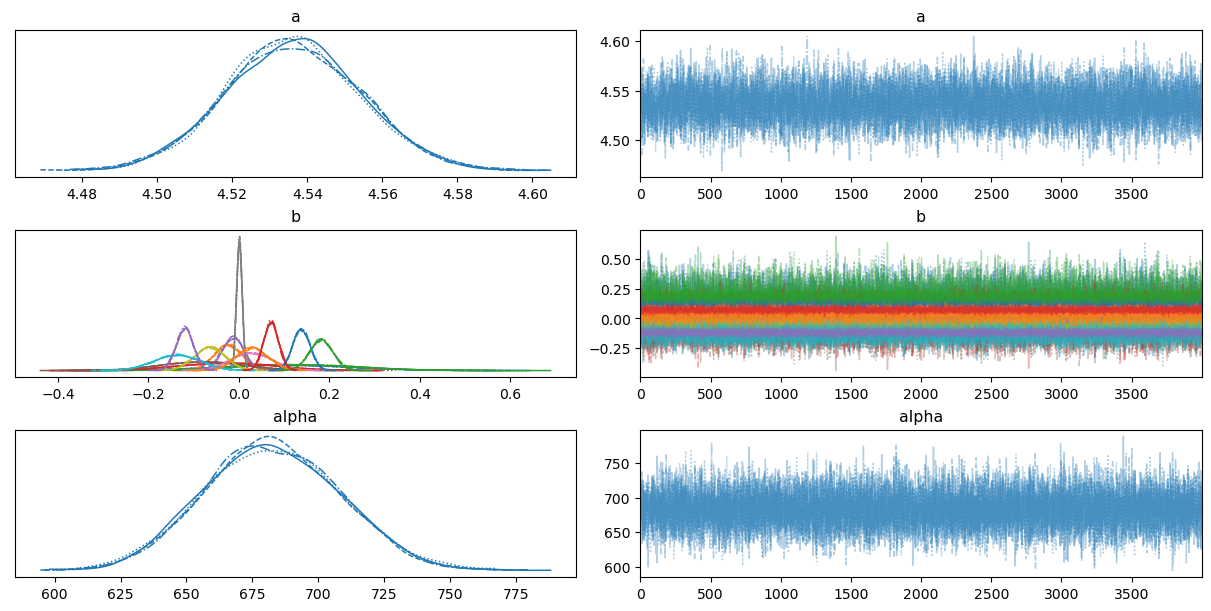

In [220]:
az.plot_trace(free_fix_empathy_trace);

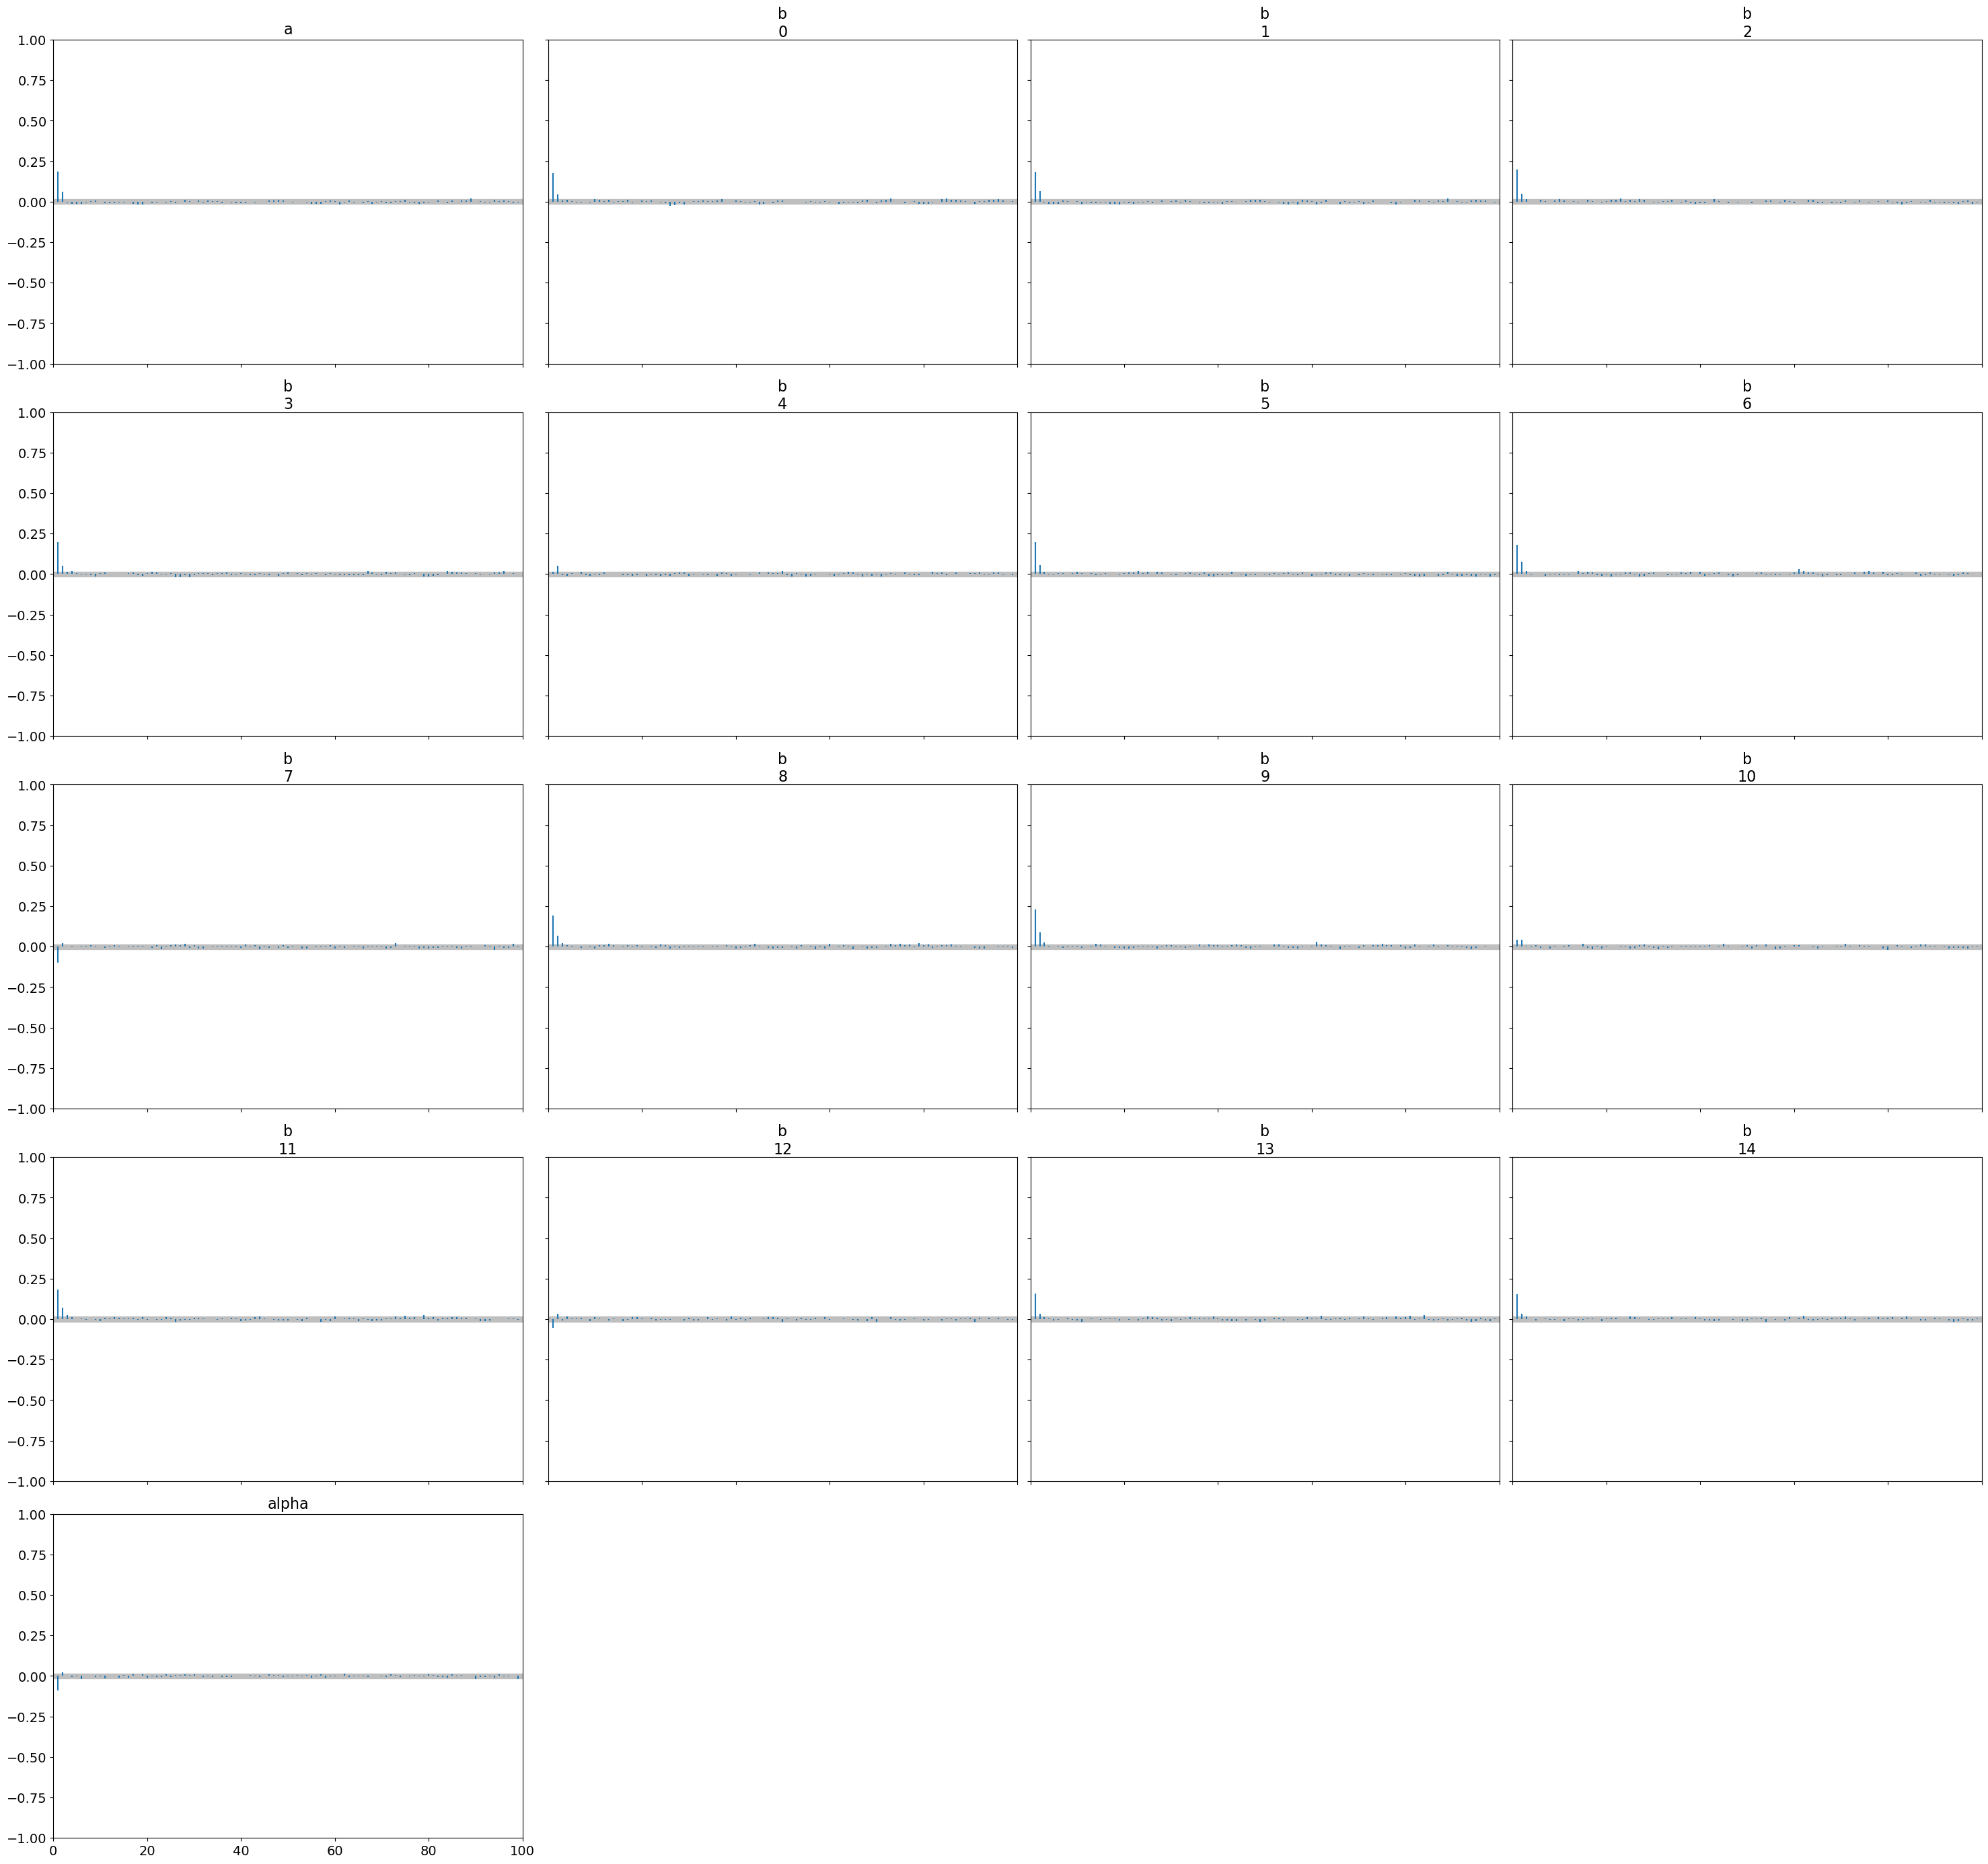

In [221]:
az.plot_autocorr(free_fix_empathy_trace, combined=True);

__Posterior predictive check__

In [222]:
with free_fix_empathy:
    fix_free_ppc = pm.sample_posterior_predictive(free_fix_empathy_trace)

In [223]:
fix_free_ppc_data = az.from_pymc3(model=free_fix_empathy, posterior_predictive=fix_free_ppc) 
fix_free_sampled_labels = fix_free_ppc_data.posterior_predictive['empathy'].to_numpy().mean(axis=(0,1))

In [224]:
mean_squared_error(free_fix_train_labels, fix_free_sampled_labels, squared= False)

8.001735183072913

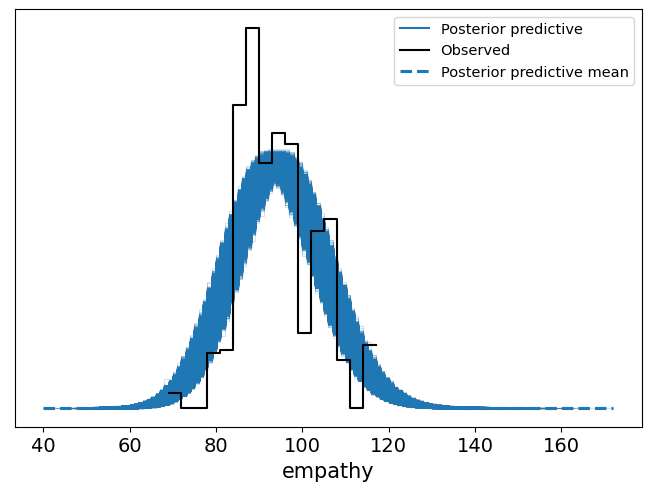

In [225]:
az.plot_ppc(fix_free_ppc_data);

__Test predictions__

In [226]:
free_fix_test_features = []
free_fix_test_labels = []

for filename in os.listdir(f"{AGGREGATED_PATH}/test/"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr % 2 == 0:
        features, labels = get_fix_free_features(sub_nr, dset="test")
        for feature in features:
            free_fix_test_features.append(feature)
        for label in labels:
            free_fix_test_labels.append(label)

free_fix_test_features = np.array(free_fix_test_features)
free_fix_test_features = (free_fix_test_features - free_fix_test_features.min(axis=0))/(free_fix_test_features.max(axis=0)-free_fix_test_features.min(axis=0))
free_fix_test_labels = np.array(free_fix_test_labels)

In [227]:
with free_fix_empathy:
    pm.set_data({"x": free_fix_test_features})
    fix_free_predictions = pm.sample_posterior_predictive(free_fix_empathy_trace)

In [228]:
fix_free_predictions = fix_free_predictions["empathy"].mean(axis = 0)
mean_squared_error(free_fix_test_labels, fix_free_predictions, squared= False)

8.229409726094339

### __Saccades__

In [14]:
def get_sac_free_features(sub_nr, dset="train"):
    with open(
        f"{AGGREGATED_PATH}/{dset}/event_features_{sub_nr:02}_agg.pickle", "rb"
    ) as f:
        sac_features = pickle.load(f)[1]
    labels = np.repeat(free_viewing_empathy[sub_nr], len(sac_features))
    return sac_features, labels

In [15]:
free_sac_train_features = []
free_sac_train_labels = []

for filename in os.listdir(f"{AGGREGATED_PATH}/test/"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr % 2 == 0:
        features, labels = get_sac_free_features(sub_nr)
        for feature in features:
            free_sac_train_features.append(feature)
        for label in labels:
            free_sac_train_labels.append(label)

free_sac_train_features = np.array(free_sac_train_features)
free_sac_train_features = (free_sac_train_features - free_sac_train_features.min(axis=0))/(free_sac_train_features.max(axis=0)-free_sac_train_features.min(axis=0))
free_sac_train_labels = np.array(free_sac_train_labels)

In [65]:
with pm.Model() as free_sac_empathy:
    X = pm.Data("x", free_sac_train_features)
    y = pm.Data("y", free_sac_train_labels)

    a = pm.Normal("intercept", mu= 0, sigma= 20)
    b = pm.Normal("beta", mu=0, sigma=20, shape=X.eval().shape[1])

    alpha = pm.Exponential("alpha", 0.5)
    λ = pm.math.exp(a + T.dot(X, b.T))

    pm.NegativeBinomial("empathy", mu=λ, alpha=alpha, observed=free_sac_train_labels, shape = X.eval().shape[0])

    free_sac_empathy_trace = pm.sample(4000, tune=3000)


Sampling 4 chains for 3_000 tune and 4_000 draw iterations (12_000 + 16_000 draws total) took 852 seconds.


In [66]:
with open("models/free_sac_empathy_20_20_05", 'wb') as buff:
    pickle.dump({'model': free_sac_empathy, 'trace': free_sac_empathy_trace}, buff)

__Model checking__

In [16]:
with open("models/free_sac_empathy_20_20_05", 'rb') as buff:
    model_data = pickle.load(buff)
    free_sac_empathy = model_data["model"]
    free_sac_empathy_trace = model_data["trace"]

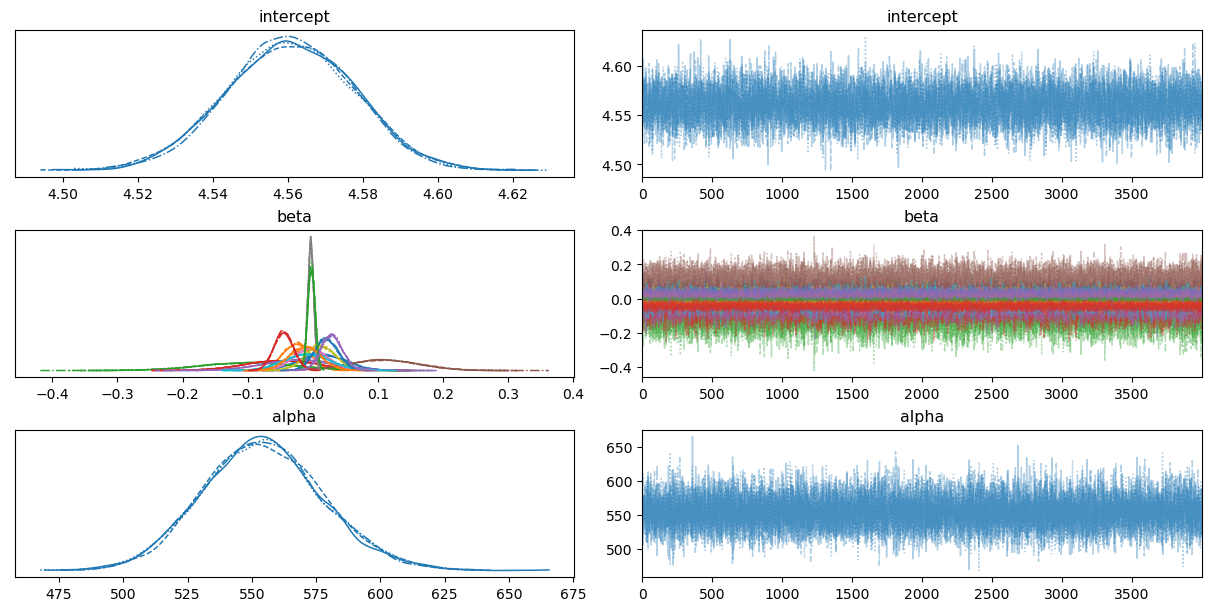

In [67]:
trace = az.plot_trace(free_sac_empathy_trace)

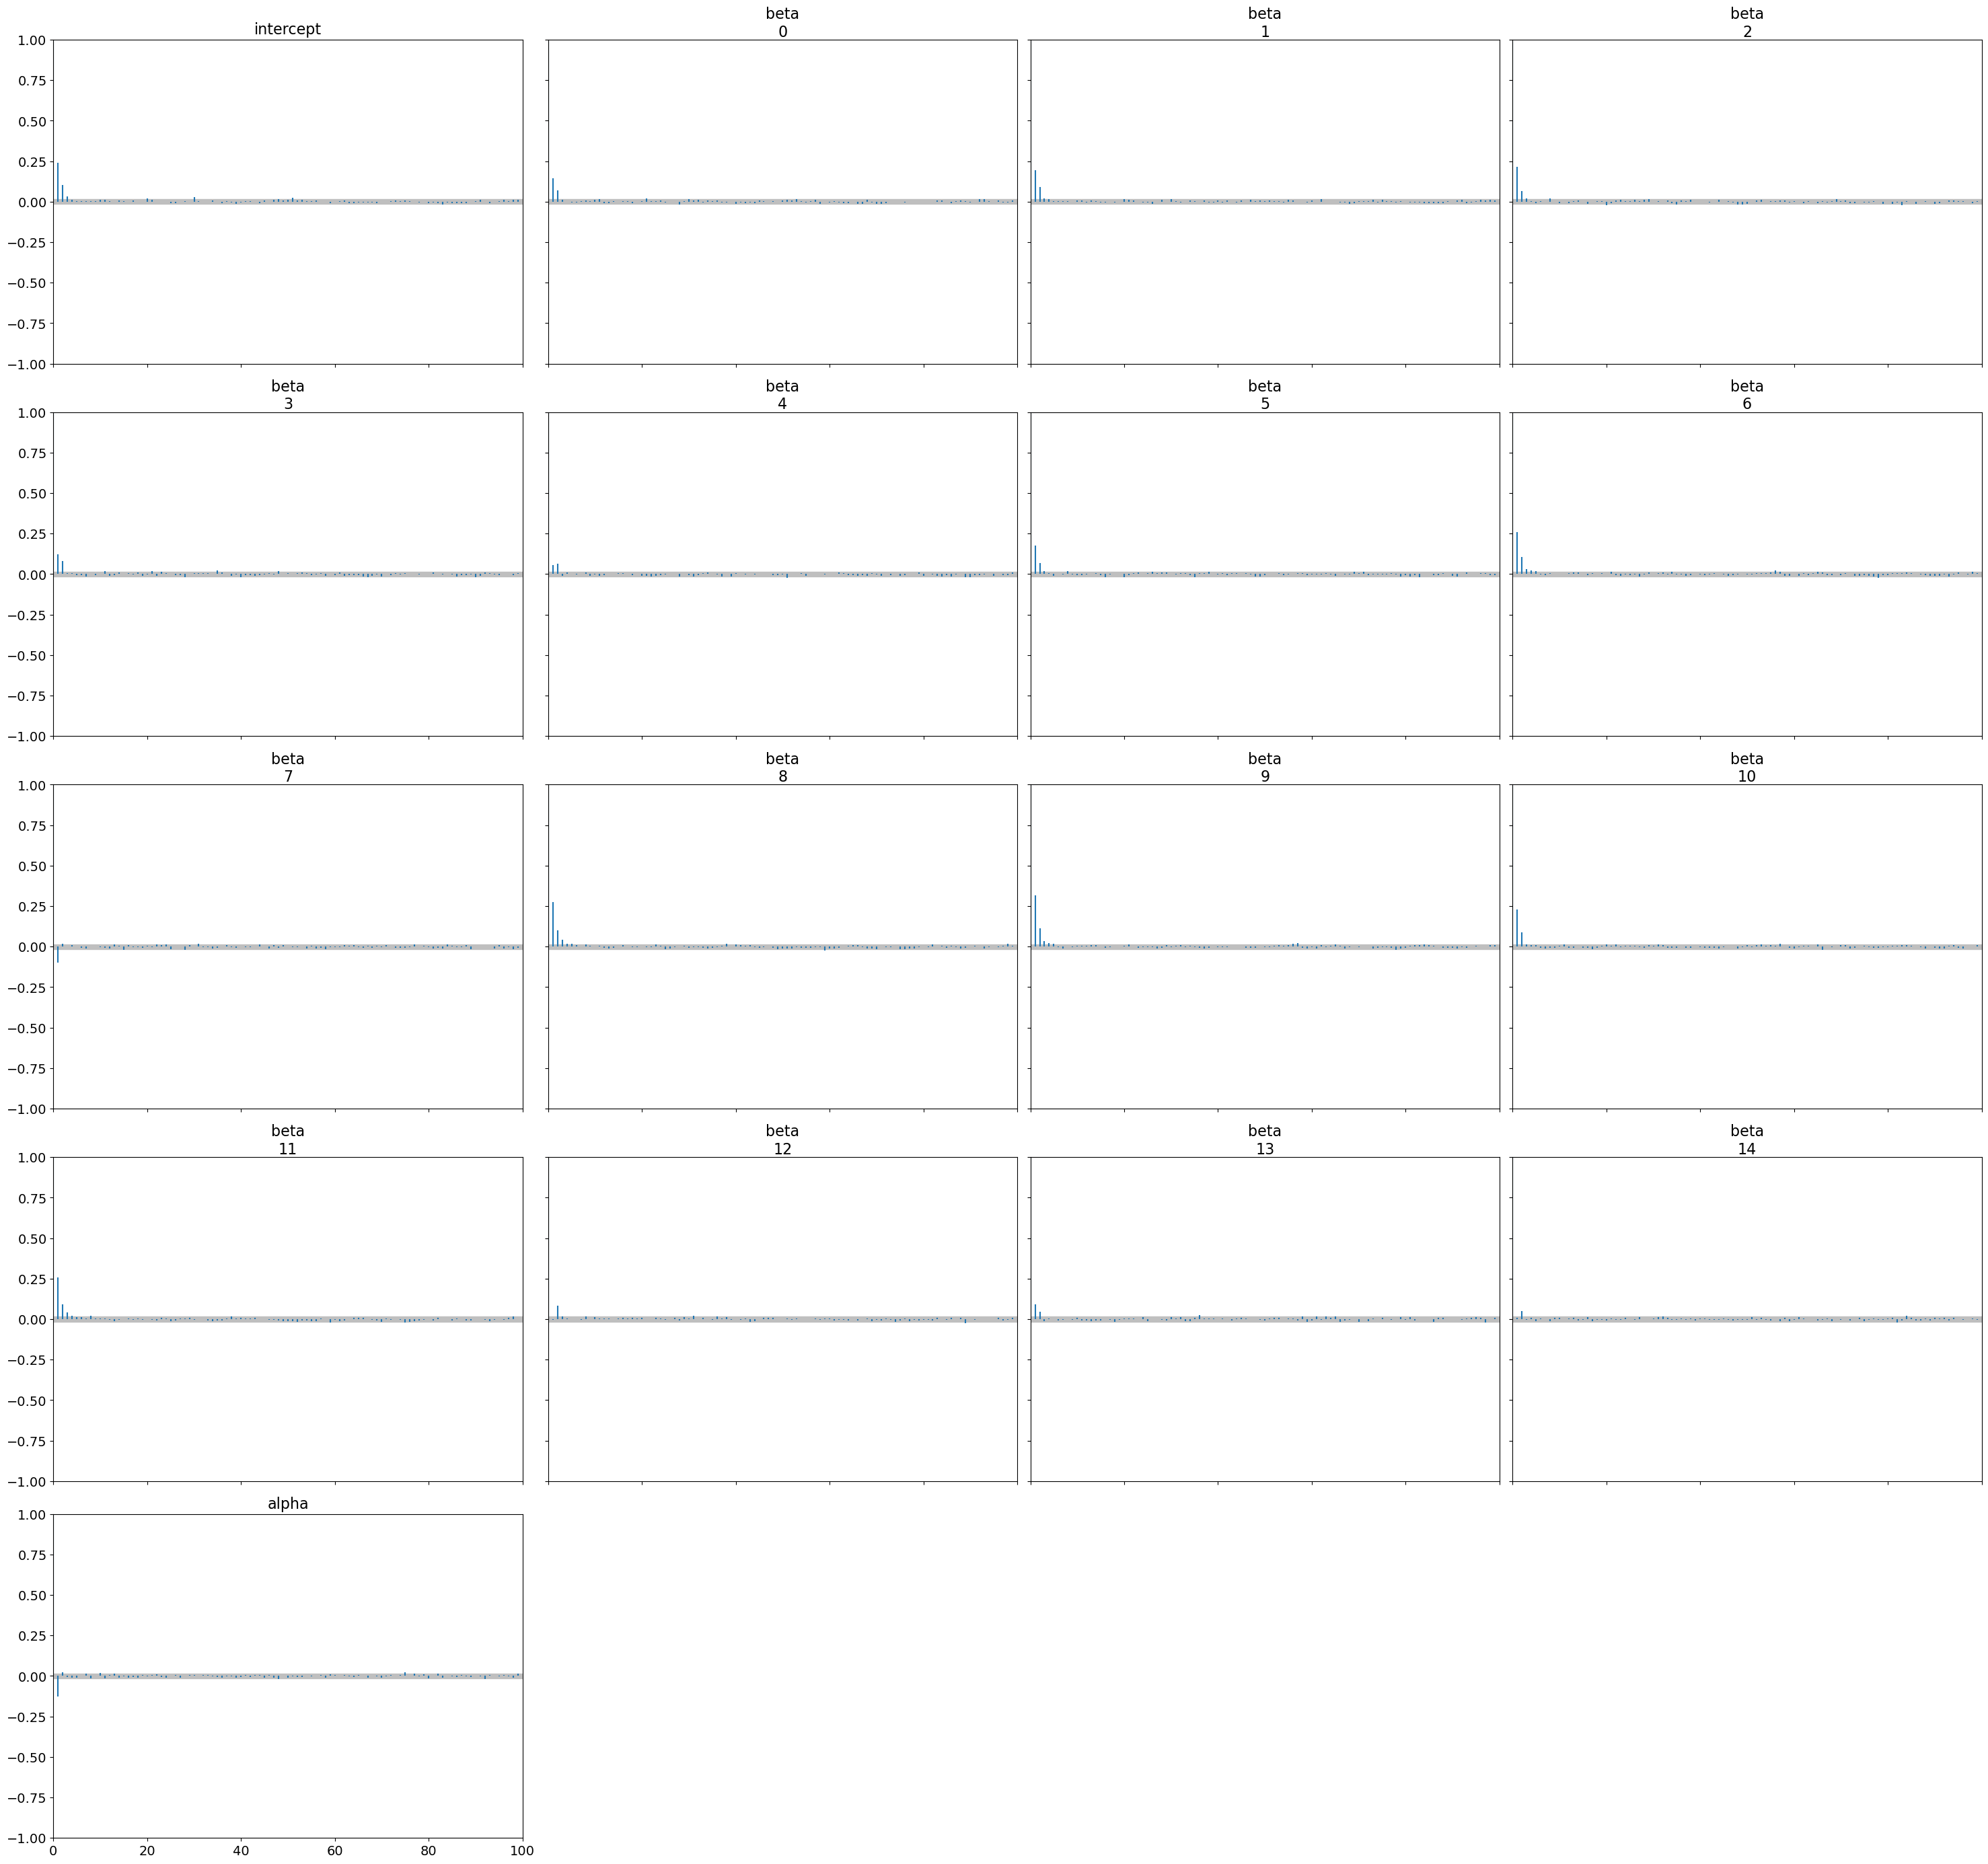

In [69]:
az.plot_autocorr(free_sac_empathy_trace, combined=True);

In [70]:
with free_sac_empathy:
    sac_free_ppc = pm.sample_posterior_predictive(free_sac_empathy_trace)
    sac_free_ppc_data = az.from_pymc3(model=free_sac_empathy, posterior_predictive=sac_free_ppc) 
    sac_free_sampled_labels = sac_free_ppc_data.posterior_predictive['empathy'].to_numpy().mean(axis=(0,1))

In [71]:
from sklearn.metrics import mean_squared_error
mean_squared_error(free_sac_train_labels, sac_free_sampled_labels, squared= False)

8.21154790110872

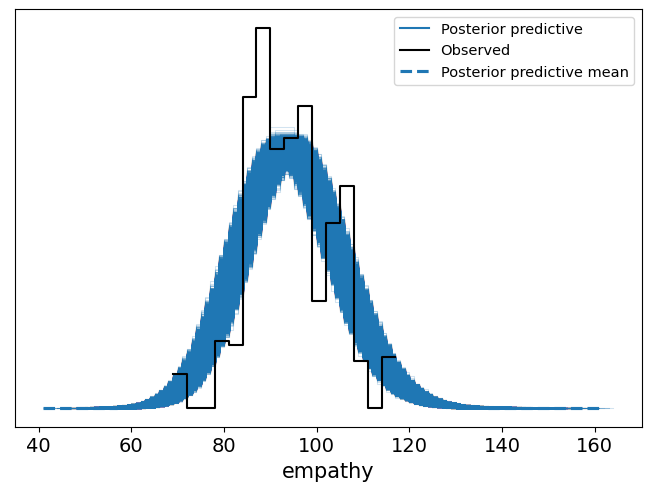

In [72]:
az.plot_ppc(sac_free_ppc_data);

__Test predictions__

In [20]:
free_sac_test_features = []
free_sac_test_labels = []

for filename in os.listdir(f"{AGGREGATED_PATH}/test/"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr % 2 == 0:
        features, labels = get_sac_free_features(sub_nr, dset="test")
        for feature in features:
            free_sac_test_features.append(feature)
        for label in labels:
            free_sac_test_labels.append(label)

free_sac_test_features = np.array(free_sac_test_features)
free_sac_test_features = (free_sac_test_features - free_sac_test_features.min(axis=0))/(free_sac_test_features.max(axis=0)-free_sac_test_features.min(axis=0))
free_sac_test_labels = np.array(free_sac_test_labels)

In [21]:
with free_sac_empathy:
    pm.set_data({"x": free_sac_test_features})
    free_sac_predictions = pm.sample_posterior_predictive(free_sac_empathy_trace)

In [24]:
sac_free_predictions = free_sac_predictions["empathy"].mean(axis = 0)
mean_squared_error(free_sac_test_labels, sac_free_predictions, squared= False)

8.309960669206149

__Combined prediction__

In [229]:
free_fix_stimuli = []
free_sac_stimuli = []

for filename in os.listdir(f"{AGGREGATED_PATH}/train/"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr % 2 == 0:
        with open(f"{AGGREGATED_PATH}/test/event_features_{sub_nr:02}_agg.pickle", "rb") as f:
            _, _, fix_stimuli, sac_stimuli = pickle.load(f)
            for stim in fix_stimuli:
                free_fix_stimuli.append((stim[0], sub_nr))
            for stim in sac_stimuli:
                free_sac_stimuli.append((stim[0], sub_nr))


In [230]:
from itertools import groupby
from operator import itemgetter
from collections import Counter

fix_predicted_empathy = {}

fix_stimulus_groups = [list(group)for key, group in groupby(list(zip(fix_free_predictions,free_fix_stimuli)), itemgetter(1))]
for fix_stimulus in fix_stimulus_groups:
    fix_predicted_empathy[(fix_stimulus[0][1][0], fix_stimulus[0][1][1])] = np.mean([value[0] for value in fix_stimulus])

sac_predicted_empathy = {}
sac_stimulus_groups = [list(group)for key, group in groupby(list(zip(sac_free_predictions,free_sac_stimuli)), itemgetter(1))]
for sac_stimulus in sac_stimulus_groups:
    sac_predicted_empathy[(sac_stimulus[0][1][0], sac_stimulus[0][1][1])] = np.mean([value[0] for value in sac_stimulus])

predicted_empathy = dict(pd.DataFrame([fix_predicted_empathy, sac_predicted_empathy]).mean())
real_empathy_values = [free_viewing_empathy[k[1]] for k in predicted_empathy.keys()]
predicted_empathy_values = list(predicted_empathy.values())
mean_squared_error(predicted_empathy_values, real_empathy_values, squared=False)

9.016834321086556

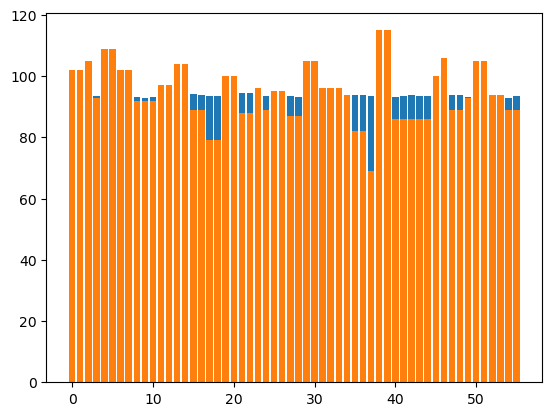

In [231]:
plt.bar(range(len(predicted_empathy_values)), predicted_empathy_values)
plt.bar(range(len(real_empathy_values)), real_empathy_values)
plt.show()